# Autoencoder for Anomaly Detection

Here we use an autoencoder for anomaly detection. Basically this method works as follows:
1. We have a training and a test set for the autoencoder and a traing and a test set for the anomaly detection. All sets are drawn from a benign distribution except for the test set of the anomaly detection, which is drawn half from the benign distribution and half from a malicious distribution.
2. We train and validate the autoencoder with the training and test sets for the autoencoder (haha).
3. We determine the highest reconstruction loss from the autoencoder on the anomaly detection training set. This maximum is our anomaly threshold.
4. Finally, we determine the reconstruction losses of all samples in the anomaly detection test set and classify all samples with a reconstruction loss greater than the anomaly threshold as malicious.

In [1]:
import random
import pandas as pd
import numpy as np

# set tensorlfow version in google colab
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow
print(tensorflow.__version__)

2.2.0-rc3


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.context('ggplot')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Generate Random Sequence Data for Training and Test Sets

In [0]:
# Create a benign and a malicious distribution for the test and training sets

part1 =  'ABCDEF'
part2 = '012'
part3 = 'QWOPZXML'
benign_source = [part1, part2, part3]

part1 = 'GHIJKL'
part2 = '013'
part3 = 'QWOPZXML'
malicious_source = [part1, part2, part3]

def get_random_strings(source, number_samples):
  strings = []
  for i in range(number_samples):
    part1 = ''.join(random.choice(source[0]) for i in range(4))
    part2 = random.choice(source[1])
    part3 = ''.join(random.choice(source[2]) for i in range(3))
    strings.append(part1 + part2 + part3)
  return strings

In [0]:
# Create test and training sets
#
# We create
# 1) two training sets from the benign distribution (one for the autoencoder and
#    one for the anomaly detection),
# 2) a encoder test set from the benign distribution and
# 3) a anomaly detection test set to one half from the benign distribution and
#    one half from the malicious distribution.

X_train_encoder = get_random_strings(benign_source, 40000)
X_train_anom_det = get_random_strings(benign_source, 20000)

X_test_encoder = get_random_strings(benign_source, 1000)
X_test_anom_det = get_random_strings(benign_source, 5000)
X_test_anom_det.extend(get_random_strings(malicious_source, 5000))
anom_det = pd.DataFrame(X_test_anom_det)
anom_det['label'] = [0 for i in range(5000)] + [1 for i in range(5000)]

## Prepare the Data

In [0]:
# Encode each string of the training and test sets to an integer array

chars = 'abcdefghijklmnopqrstuvwxyz'\
      + 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'\
      + '0123456789'

char_to_int = dict((c, i) for i, c in enumerate(chars))

def encode_sequence_list(sequence_list):
  encoded_sequences = []
  for sequence in sequence_list:
    encoded_sequence = [char_to_int[c] for c in sequence]
    encoded_sequences.append(encoded_sequence)
  return encoded_sequences

X_train_encoder = encode_sequence_list(X_train_encoder)
X_train_anom_det = encode_sequence_list(X_train_anom_det)

X_test_encoder = encode_sequence_list(X_test_encoder)
X_test_anom_det = encode_sequence_list(X_test_anom_det)

In [0]:
# Scale training and test sets using minmaxscaler
#
# MinMaxScaler subtracts the minimum value in the feature and then divides by
# the range. The range is the difference between the original maximum and
# original minimum.

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler = scaler.fit(X_train_encoder)

X_train_encoder = scaler.transform(X_train_encoder)
X_train_anom_det = scaler.transform(X_train_anom_det)

X_test_encoder = scaler.transform(X_test_encoder)
X_test_anom_det = scaler.transform(X_test_anom_det)

## Design the Architecture of the Autoencoder

In [0]:
# Design the model architecture of the Autoencoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import ActivityRegularization
from tensorflow.keras import regularizers

# number of features
input_dim = X_train_encoder.shape[1]
hidden_dim = int(input_dim / 2)

model = Sequential()
# encoder
model.add(Dense(input_dim))
model.add(Activation('tanh'))
model.add(Dense(hidden_dim))
model.add(Activation('relu'))

# decoder
model.add(Dense(hidden_dim))
model.add(Activation('relu'))
model.add(Dense(input_dim))
model.add(Activation('tanh'))

## Compile and Fit the Model

In [0]:
# Set trainings parameters

epochs = 64
batch_size = 32
learning_rate = 0.03

In [9]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

history = model.fit(X_train_encoder, X_train_encoder,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test_encoder, X_test_encoder),
                    verbose=1)

Epoch 1/64
1250/1250 [==============================] - 3s 2ms/step - loss: 0.1633 - accuracy: 0.1515 - val_loss: 0.1154 - val_accuracy: 0.2420
Epoch 2/64
1250/1250 [==============================] - 2s 2ms/step - loss: 0.1025 - accuracy: 0.2176 - val_loss: 0.0958 - val_accuracy: 0.2260
Epoch 3/64
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0962 - accuracy: 0.2174 - val_loss: 0.0943 - val_accuracy: 0.2290
Epoch 4/64
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0949 - accuracy: 0.2288 - val_loss: 0.0932 - val_accuracy: 0.2420
Epoch 5/64
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0935 - accuracy: 0.2451 - val_loss: 0.0916 - val_accuracy: 0.2490
Epoch 6/64
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0920 - accuracy: 0.2625 - val_loss: 0.0907 - val_accuracy: 0.2670
Epoch 7/64
1250/1250 [==============================] - 2s 2ms/step - loss: 0.0912 - accuracy: 0.2675 - val_loss: 0.0899 - val_accuracy:

Text(0, 0.5, 'Accuracy')

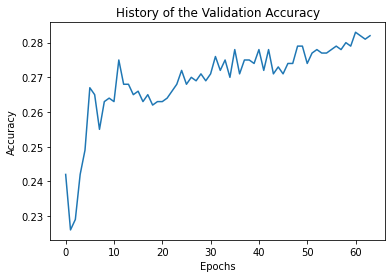

In [10]:
plt.plot(history.history['val_accuracy'])
plt.title('History of the Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

## Calculate the Anomaly-Threshold

anomaly threshold:  0.23541017005849607


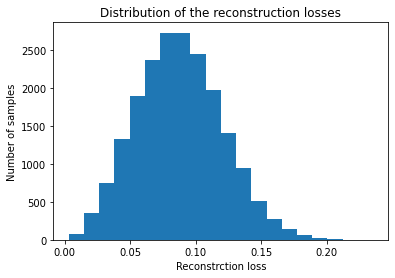

In [11]:
# get the MSE error term for each
predictions = model.predict(X_train_anom_det)
mse = np.mean(np.power(X_train_anom_det - predictions, 2), axis=1)
plt.hist(mse, bins=20)
plt.title('Distribution of the reconstruction losses')
plt.xlabel('Reconstrction loss')
plt.ylabel('Number of samples')
anom_threshold = np.max(mse)
#anom_threshold = np.quantile(mse, 0.9999)
print('anomaly threshold: ', anom_threshold)

## Predict

In [12]:
predicted = model.predict(X_test_anom_det)
mse = np.mean(np.power(X_test_anom_det - predicted, 2), axis=1)
anom_det['mse'] = mse
display(anom_det)

,0,label,mse
0,AFCA1LZX,0,0.195792
1,FEEE0XPX,0,0.079955
2,FABD2LWM,0,0.105761
3,CBCF2OPL,0,0.061690
4,DCDA2QOW,0,0.026158
...,...,...,...
9995,LLHI0OLL,1,0.957003
9996,GIJJ0ZPZ,1,0.656040
9997,JHJH0PLZ,1,0.659342
9998,IJJJ3PLM,1,0.836350


In [13]:
anom_det['anom_pred'] = 0
anom_det.loc[anom_det['mse'] > anom_threshold, 'anom_pred'] = 1
display(anom_det)

,0,label,mse,anom_pred
0,AFCA1LZX,0,0.195792,0
1,FEEE0XPX,0,0.079955,0
2,FABD2LWM,0,0.105761,0
3,CBCF2OPL,0,0.061690,0
4,DCDA2QOW,0,0.026158,0
...,...,...,...,...
9995,LLHI0OLL,1,0.957003,1
9996,GIJJ0ZPZ,1,0.656040,1
9997,JHJH0PLZ,1,0.659342,1
9998,IJJJ3PLM,1,0.836350,1


## Evaluation of the Anomaly Detection

In [14]:
true_positives = anom_det.loc[(anom_det['label']==1) &
                              (anom_det['anom_pred']==1), 'label'].count()
false_positives = anom_det.loc[(anom_det['label']==0) &
                               (anom_det['anom_pred']==1), 'label'].count()
precision = true_positives / (true_positives + false_positives)
recall = true_positives / anom_det.loc[anom_det['label']==1, 'label'].count()

print('True positives: ', true_positives)
print('False positives: ', false_positives)
print('Precision: ', precision)
print('Recall: ', recall)

True positives:  5000
False positives:  0
Precision:  1.0
Recall:  1.0
